In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.stattools import adfuller
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix

In [2]:
sensor_df = pd.read_csv('sensor.csv')
sensor_df.shape

(220320, 55)

In [3]:
# Check null values percent
percent_null = sensor_df.iloc[:, 2:].isnull().mean() * 100
print(sorted(percent_null.items(), key=lambda x: x[1], reverse=True))

[('sensor_15', 100.0), ('sensor_50', 34.95688090050835), ('sensor_51', 6.982116920842412), ('sensor_00', 4.633260711692085), ('sensor_07', 2.474128540305011), ('sensor_08', 2.3179920116194626), ('sensor_06', 2.177741466957153), ('sensor_09', 2.0856027596223674), ('sensor_01', 0.16748366013071894), ('sensor_30', 0.1184640522875817), ('sensor_29', 0.0326797385620915), ('sensor_32', 0.030864197530864196), ('sensor_17', 0.020878721859114015), ('sensor_18', 0.020878721859114015), ('sensor_22', 0.018609295570079884), ('sensor_25', 0.01633986928104575), ('sensor_16', 0.014070442992011621), ('sensor_38', 0.012254901960784314), ('sensor_39', 0.012254901960784314), ('sensor_40', 0.012254901960784314), ('sensor_41', 0.012254901960784314), ('sensor_42', 0.012254901960784314), ('sensor_43', 0.012254901960784314), ('sensor_44', 0.012254901960784314), ('sensor_45', 0.012254901960784314), ('sensor_46', 0.012254901960784314), ('sensor_47', 0.012254901960784314), ('sensor_48', 0.012254901960784314), ('s

In [4]:
# Drop the null columns
sensor_df.drop(columns=['sensor_15'], inplace=True)
sensor_df.drop(columns=['sensor_50'], inplace=True)
sensor_df.drop(columns=['Unnamed: 0'], inplace=True)

# Replace RECOVERING with NORMAL
sensor_df['machine_status'] = sensor_df['machine_status'].replace('RECOVERING', 'NORMAL')
sensor_df.shape

(220320, 52)

In [5]:
print(sensor_df['machine_status'].astype('category').unique())

['NORMAL', 'BROKEN']
Categories (2, object): ['BROKEN', 'NORMAL']


In [6]:
# Find anomaly records
broken_rec = sensor_df[sensor_df['machine_status'] == 'BROKEN'] 
broken_rec

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
17155,2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,16.869210,...,36.979160,50.78125,50.92593,51.215280,50.636570,46.006940,409.143500,121.527800,324.6528,BROKEN
24510,2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,14.185470,...,29.947916,42.70833,34.72222,31.539350,34.432870,33.275460,59.895830,44.560180,183.7384,BROKEN
69318,2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,15.147570,...,31.250000,39.06250,35.01157,37.905090,39.062500,45.428240,144.675900,49.768520,257.5231,BROKEN
77790,2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,15.943290,...,176.822900,202.34370,65.68287,57.870370,127.893500,153.935200,155.381900,65.682870,267.3611,BROKEN
128040,2018-06-28 22:00:00,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.335360,15.270540,15.183740,...,24.739580,32.29166,28.06713,28.067129,29.513889,29.224537,29.224537,29.513889,NaN,BROKEN
141131,2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,0.036169,...,32.812500,36.19791,37.32639,35.300930,38.194440,43.402780,99.537030,44.849540,174.7685,BROKEN
166440,2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,15.697340,...,36.458330,51.30208,52.10200,52.662040,67.129630,43.981480,230.324100,69.733800,205.7292,BROKEN


In [7]:
def plot_sensor_data(sensor_id, df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    broken = df[df['machine_status'] == 'BROKEN']
    df2 = df.drop(['machine_status', 'timestamp'], axis=1)
    sensor_names = df2.columns
    sensor_type = sensor_names[sensor_id]
    
    sns.set_context('talk')
    plt.figure(figsize=(20, 5))
    plt.plot(df['timestamp'], df2[sensor_type], color='royalblue', label='Normal', linewidth=1.5)
    for i in broken['timestamp']:
        plt.axvline(x=i, color='red', linestyle='--', linewidth=1.5, label='Broken' if i == broken['timestamp'].iloc[0] else "")
    
    plt.title(f'{sensor_type}', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.xticks(ticks=broken['timestamp'], labels=broken['timestamp'].dt.strftime("%Y-%m-%d"), rotation=45)

    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

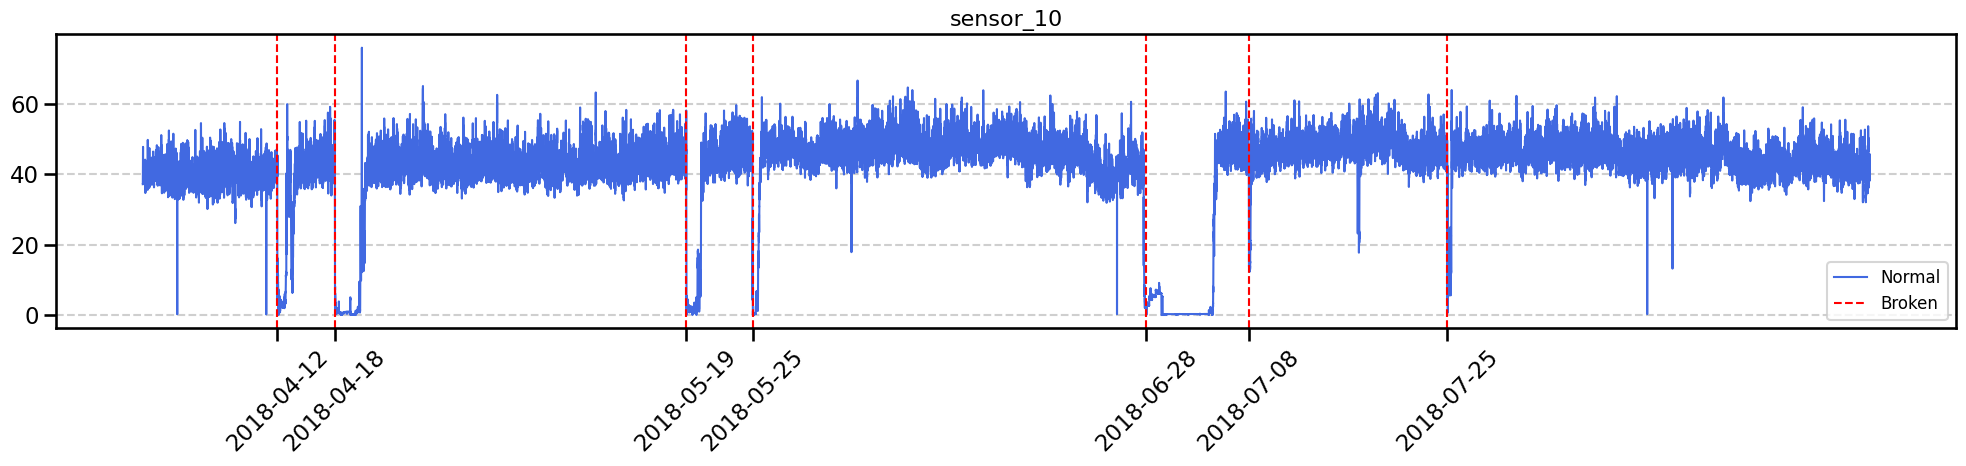

In [8]:
# Plot sensor data of sensors
plot_df = sensor_df.copy()
plot_sensor_data(10, plot_df)

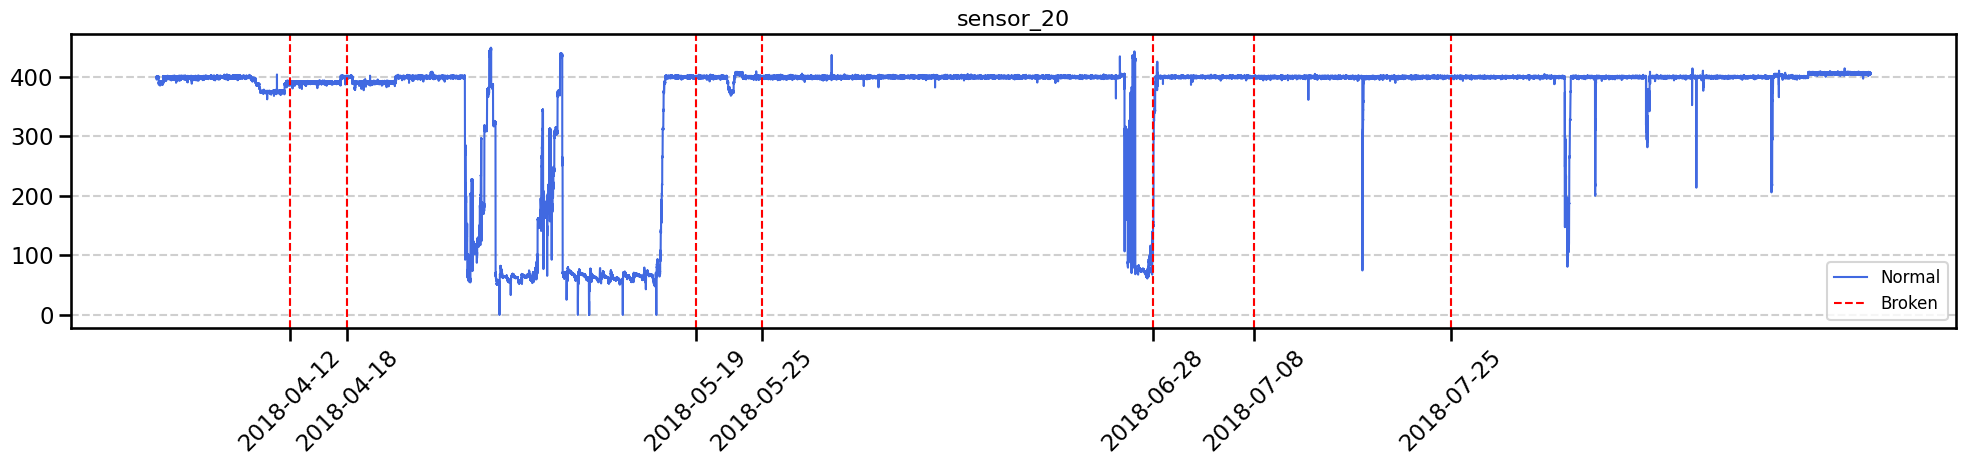

In [9]:
plot_sensor_data(19, plot_df)

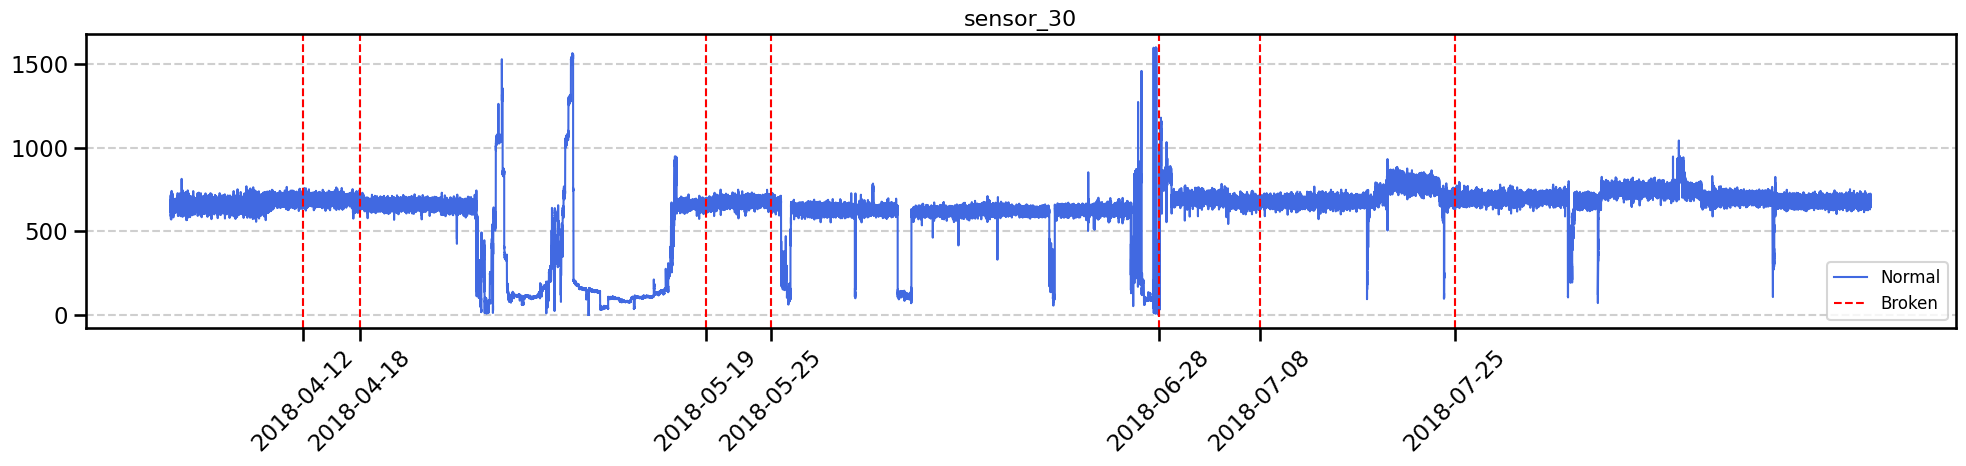

In [10]:
plot_sensor_data(29, plot_df)

In [11]:
sensor_df2 = sensor_df.copy()
sensor_df2['timestamp'] = pd.to_datetime(sensor_df2['timestamp'])
sensor_df2 = sensor_df2.sort_values(by='timestamp')
broke_date = sensor_df2[sensor_df2['machine_status'] == 'BROKEN']['timestamp']

In [12]:
# Handle missing values
sensor_df2.ffill(inplace=True)
sensor_df3 = sensor_df2.copy()

### PCA Processing

In [13]:
# PCA 
sensor_train_df = sensor_df3.drop(columns=['timestamp', 'machine_status'])
names = sensor_train_df.columns
x = sensor_train_df[names]
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

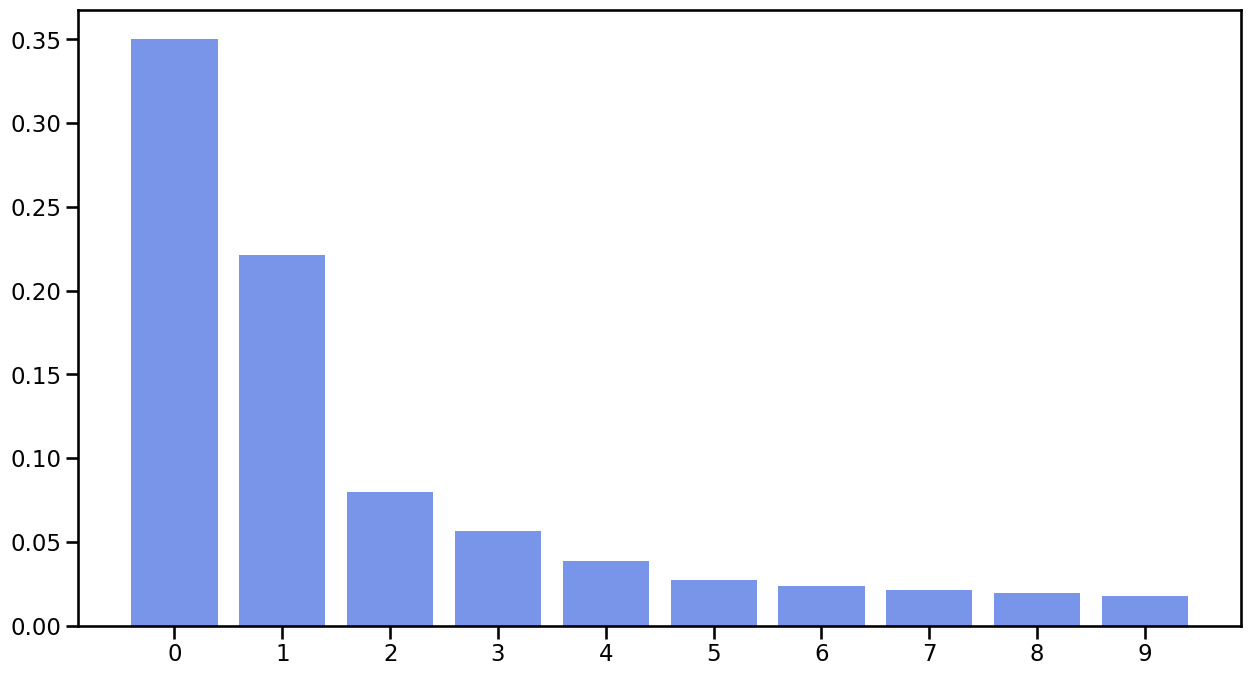

In [14]:
plt.figure(figsize=(15, 8))
plt.bar(range(10), pca.explained_variance_ratio_[:10], color='royalblue', alpha=0.7, align='center')
plt.xticks(range(10))
plt.show()

In [15]:
pca_ratio = pca.explained_variance_ratio_
percent_variance = 0
num_chosen_components = 5
for i in range(num_chosen_components):
    percent_variance += pca_ratio[i]

print(f'{num_chosen_components} components explain {percent_variance * 100:.2f}% of the variance')

5 components explain 74.67% of the variance


In [16]:
pca = PCA(n_components=num_chosen_components)
p_components = pca.fit_transform(x)
p_df = pd.DataFrame(data=p_components, columns=[f'PC{i+1}' for i in range(num_chosen_components)])
p_df.shape

(220320, 5)

In [17]:
for i in range(1, num_chosen_components + 1):
    sensor_df3[f'PC{i}'] = p_df[f'PC{i}']
sensor_df3.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_47,sensor_48,sensor_49,sensor_51,machine_status,PC1,PC2,PC3,PC4,PC5
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,38.194440,157.9861,67.70834,201.3889,NORMAL,-68.962905,-293.450257,-90.308930,-333.906477,-256.642657
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,38.194440,157.9861,67.70834,201.3889,NORMAL,-68.962905,-293.450257,-90.308930,-333.906477,-256.642657
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,38.194443,155.9606,67.12963,203.7037,NORMAL,-27.207118,-310.109788,-85.882682,-286.059348,-281.787024
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,38.194440,155.9606,66.84028,203.1250,NORMAL,-23.875776,-314.594708,-74.429876,-255.800432,-286.137691
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,38.773150,158.2755,66.55093,201.3889,NORMAL,-29.014858,-318.904945,-71.932425,-293.999284,-249.430803


In [ ]:
# for i in range(1, num_chosen_components + 1):
#     pc_column = f'PC{i}'
#     result = adfuller(p_df[pc_column])
#     print(f'ADF test p-value for {pc_column}: {result[1]}')

### Raw value LOF

In [22]:
def plot_lof(sensor_id, df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    broken = df[df['machine_status'] == 'BROKEN']
    df2 = df.drop(['machine_status', 'timestamp'], axis=1)
    sensor_names = df2.columns
    sensor_type = sensor_names[sensor_id]
    
    sns.set_context('talk')
    plt.figure(figsize=(20, 5))
    plt.plot(df['timestamp'], df2[sensor_type], color='royalblue', label='Normal', linewidth=1.5)
    for i in broken['timestamp']:
        plt.axvline(x=i, color='green', linestyle='--', linewidth=1.5, label='Broken' if i == broken['timestamp'].iloc[0] else "")
    
    plt.scatter(df['timestamp'][df['is_outlier'] == -1], df2[sensor_type][df['is_outlier'] == -1], color='red', marker='X', s=30, label='Outlier')
    
    plt.title(f'{sensor_type}', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.xticks(ticks=broken['timestamp'], labels=broken['timestamp'].dt.strftime("%Y-%m-%d"), rotation=45)

    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

In [29]:
lof = LocalOutlierFactor(n_neighbors=100, contamination='auto')
sensor_df_train = sensor_df2.drop(columns=['timestamp', 'machine_status'])
a = StandardScaler().fit_transform(sensor_df_train)
labels = lof.fit_predict(a)
sensor_df2['is_outlier'] = labels
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

print(clusters)

[[    -1      1]
 [  4629 215691]]


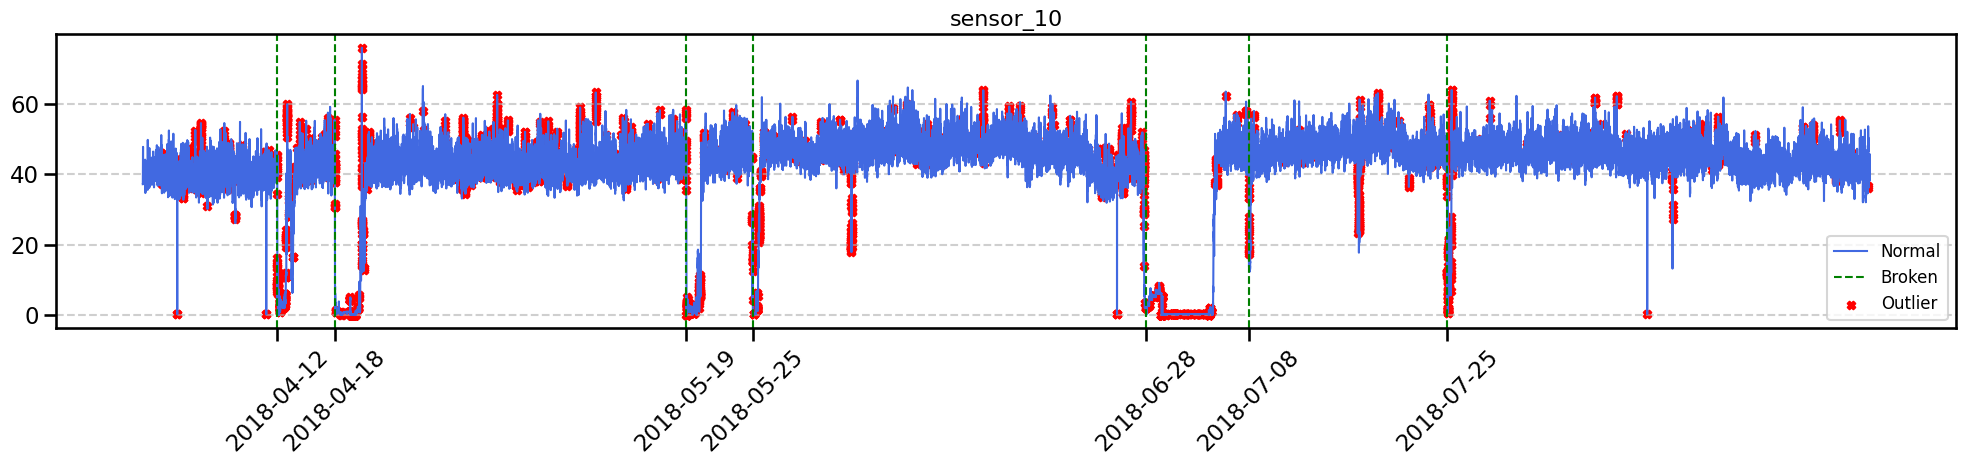

In [30]:
plot_lof(10, sensor_df2)

In [31]:
sensor_df2['machine_status'].value_counts()

machine_status
NORMAL    220313
BROKEN         7
Name: count, dtype: int64

In [32]:
outliers_counts = sensor_df2[sensor_df2['is_outlier'] == -1]['machine_status'].value_counts()
inliers_counts = sensor_df2[sensor_df2['is_outlier'] == 1]['machine_status'].value_counts()

In [33]:
if len(outliers_counts) == 1:
    if 'NORMAL' in outliers_counts:
        outliers_counts['BROKEN'] = 0
    else:
        outliers_counts['NORMAL'] = 0

/tmp/ipykernel_26219/3026598747.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [outliers_counts[1], outliers_counts[0]],
/tmp/ipykernel_26219/3026598747.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [inliers_counts[1], inliers_counts[0]]


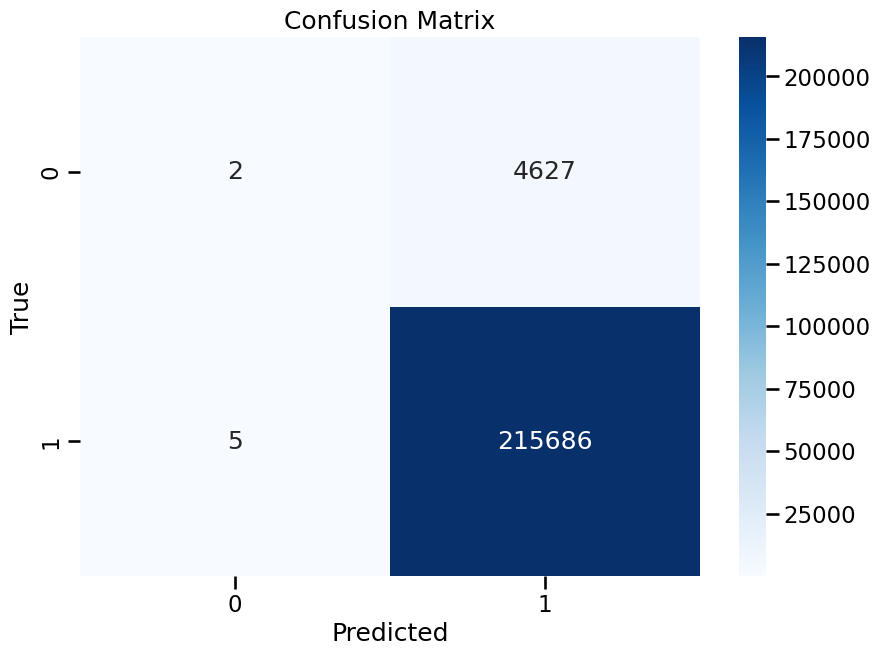

In [34]:
cm = np.array([
    [outliers_counts[1], outliers_counts[0]],
    [inliers_counts[1], inliers_counts[0]]
])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### PCA LOF

In [20]:
lof = LocalOutlierFactor(n_neighbors=100, contamination='auto')
# sensor_df_train = sensor_df3.drop(columns=['timestamp', 'machine_status'])
a = StandardScaler().fit_transform(p_df)
labels = lof.fit_predict(a)
sensor_df3['is_outlier'] = labels
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

print(clusters)

[[    -1      1]
 [  6392 213928]]


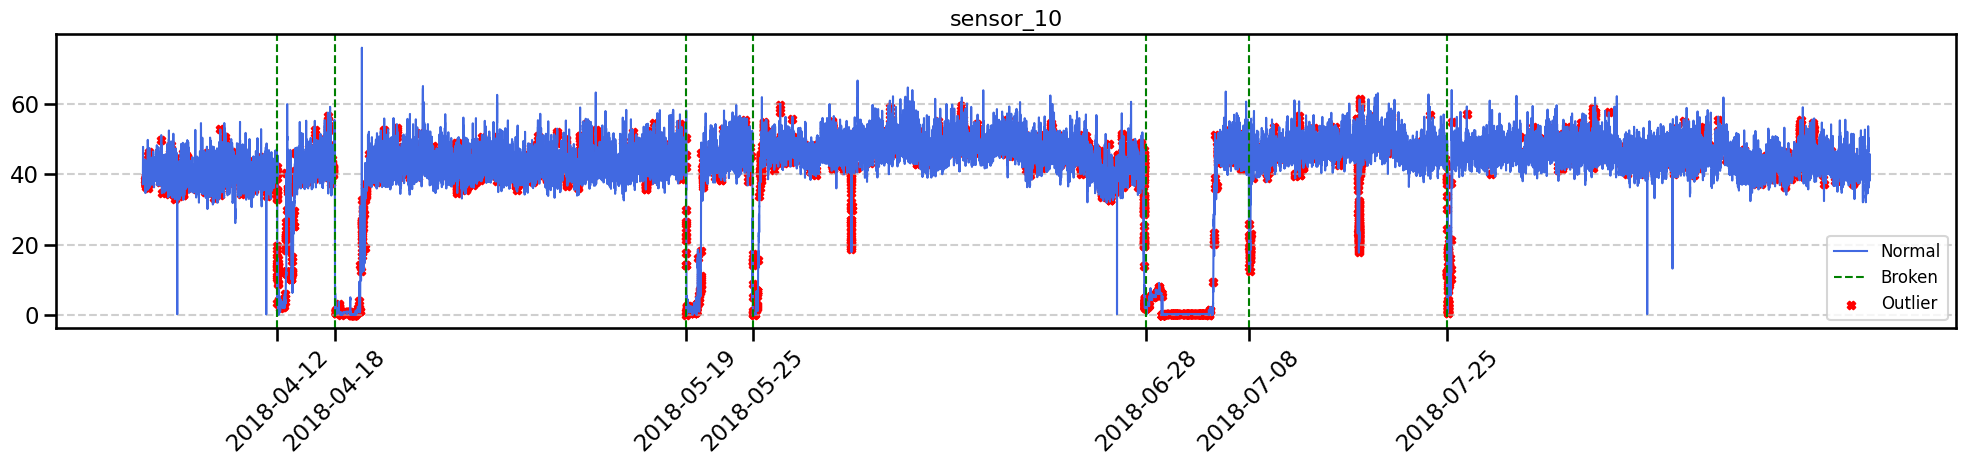

In [23]:
plot_lof(10, sensor_df3)

In [24]:
sensor_df3['machine_status'].value_counts()

machine_status
NORMAL    220313
BROKEN         7
Name: count, dtype: int64

In [25]:
outliers_counts = sensor_df3[sensor_df3['is_outlier'] == -1]['machine_status'].value_counts()
inliers_counts = sensor_df3[sensor_df3['is_outlier'] == 1]['machine_status'].value_counts()

In [26]:
outliers_counts

machine_status
NORMAL    6390
BROKEN       2
Name: count, dtype: int64

In [27]:
if len(outliers_counts) == 1:
    if 'NORMAL' in outliers_counts:
        outliers_counts['BROKEN'] = 0
    else:
        outliers_counts['NORMAL'] = 0

/tmp/ipykernel_26219/3026598747.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [outliers_counts[1], outliers_counts[0]],
/tmp/ipykernel_26219/3026598747.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [inliers_counts[1], inliers_counts[0]]


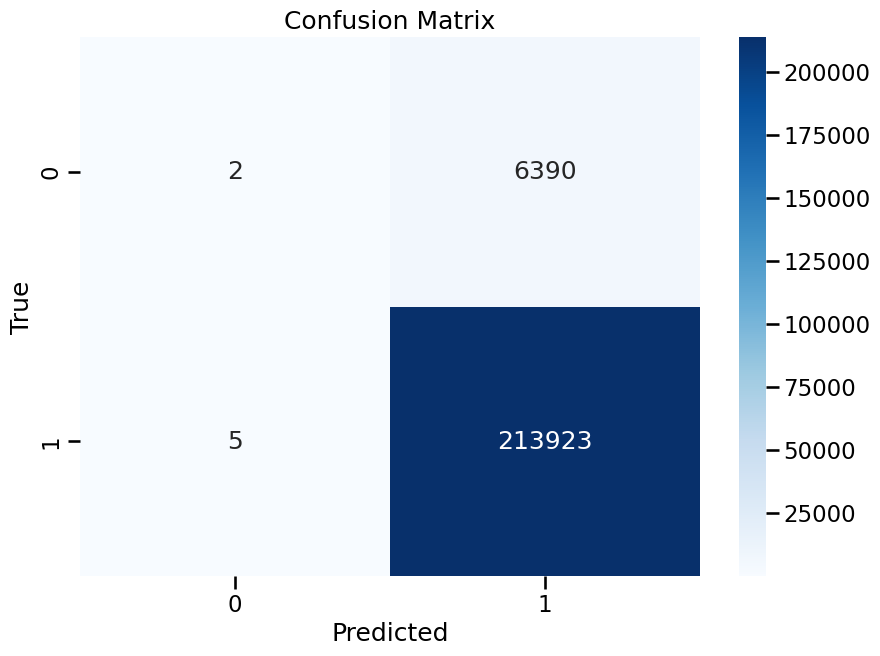

In [28]:
cm = np.array([
    [outliers_counts[1], outliers_counts[0]],
    [inliers_counts[1], inliers_counts[0]]
])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()